# 1. Практическое задание. Обучение полносвязной нейронной сети.

**ФИО**: *Козлова Екатерина Руслановна*

In [7]:
import numpy as np
import torch
import cv2
import random
from tqdm.auto import tqdm
from tqdm import trange
from statistics import mean

from glob import glob
from collections import OrderedDict
from matplotlib import pyplot as plt

from torch import nn
from torch.autograd import Function
from torch.autograd.gradcheck import gradcheck
from torch.optim import Optimizer, Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision import transforms

## 1. Загрузка данных (2 балла)

Если вам требуется работать с каким-нибубь набором данных (dataset), то прежде всего проверьте нет ли его среди встроенных наборов данных https://pytorch.org/vision/stable/datasets.html.

В текущем домашнем задании мы будем работать с набором данных FashionMNIST. Это не совсем про тексты, но зато он численный и его можно вытянуть в вектор. Это легко и полезно, чтобы отработать разные приемы. Он присутствует в списке встроенных наборов данных, однако мы воспользуемся реализацией только для удобного и быстрого способа скачать наборы данных. Ниже предлагается реализовать собственный класс для считывания, обработки и упаковки данных.

In [8]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True
)

100%|██████████| 26421880/26421880 [00:01<00:00, 18707102.16it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 304564.68it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5384616.53it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 16738199.22it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



Воспользуемся функцией загрузки данных из репозитория наборов данных.

In [9]:
! ls data/FashionMNIST/raw

t10k-images-idx3-ubyte	   t10k-labels-idx1-ubyte.gz   train-labels-idx1-ubyte
t10k-images-idx3-ubyte.gz  train-images-idx3-ubyte     train-labels-idx1-ubyte.gz
t10k-labels-idx1-ubyte	   train-images-idx3-ubyte.gz


In [10]:
#https://github.com/zalandoresearch/fashion-mnist/blob/master/utils/mnist_reader.py

def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

Для удобства PyTorch предоставляет ряд базовых классов `Dataset, DataLoader`, от которых предлагается отнаследоваться при разработке пользовательских классов. Базовый класс `Dataset` используется для загрузки и обработки данных, класс `DataLoader` используется для управления процессом загрузки данных, позволяет в многопоточном режиме загружать данные и упаковывать их.
Эти вспомогательные классы находятся в модуле `torch.utils.data`.

При наследовании от класса `torch.utils.data.Dataset` требуется переопределить метод `__len__`, который возвращает количество примеров в наборе данных, а также метод `__getitem__`, который позволяет получить доступ к примеру из набора данных по индексу.

Реализуем класс для FasionMnist.

Элементами датасета должны являться пары '(np.array, int)', массив имеет размерность `(28, 28)`, тип элемента `np.float32`.

In [11]:
import os

class FashionMnist(Dataset):
    def __init__(self, path, train=True, image_transform=None,
                 label_transform=None):
        if train:
            self.n = load_mnist(path, 'train')[1].shape[0]
            if image_transform and label_transform:
                transformed_image = image_transform(load_mnist(path, 'train')[0])
                transformed_label = label_transform(load_mnist(path, 'train')[1])
                self.dataset = list(zip(transformed_image, transformed_label))
            else:
                self.dataset = list(zip(load_mnist(path, 'train')[0], load_mnist(path, 'train')[1]))
        else:
            self.n = load_mnist(path, 't10k')[1].shape[0]
            if image_transform and label_transform:
                transformed_image = image_transform(load_mnist(path, 't10k')[0])
                transformed_label = label_transform(load_mnist(path, 't10k')[1])
                self.dataset = list(zip(transformed_image, transformed_label))
            else:
                self.dataset = list(zip(load_mnist(path, 't10k')[0], load_mnist(path, 't10k')[1]))


    def __len__(self,):
        return self.n


    def __getitem__(self, idx):
        return self.dataset[idx]

In [12]:
test_dataset = FashionMnist("data/FashionMNIST/raw", train=False)
train_dataset = FashionMnist("data/FashionMNIST/raw")

Визуализируйте случайные элементы набора данных.

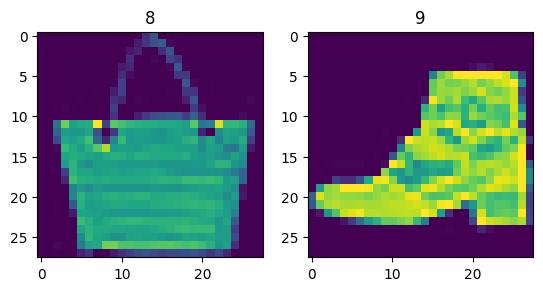

In [15]:
for i in [0, 1]:
    plt.subplot(1, 2, i + 1)
    rand_n = random.randint(0, len(train_dataset)- 1)
    plt.imshow(train_dataset[rand_n][0].reshape([28, 28]))
    plt.title(str(train_dataset[rand_n][1]))
plt.show()

В конструктор `Dataset` можно передать объект `torchvision.transforms`, который позволяет преобразовать исходные данные. Преобразование `torchvision.transforms.ToTensor` позволяет преобразоать данные из типа `PIL Image` и `numpy.float32` в тип `torch.float32`

Реализуйте собственную поддержку преобразований в `FashionMnist`. Проверьте, что приведение типов работает корректно.

In [37]:
class ToTensor:
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        return torch.from_numpy(sample).to(torch.float32)

In [38]:
transform = ToTensor()

test_dataset = FashionMnist("data/FashionMNIST/raw", train=False, image_transform=transform, label_transform=transform)
train_dataset = FashionMnist("data/FashionMNIST/raw", image_transform=transform, label_transform=transform)

Элементы набора данных могут быть объединены в пакеты (batch) явно и неявно. Если данные могут быть сконкатенированы или обЪединены каким-нибудь тривиальным способом, то можно не передавать никаких дополнительных парамертов в `torch.utils.data.Dataloader`.

In [39]:
test_dataloader = DataLoader(test_dataset, batch_size=15, num_workers=2, shuffle=True)
train_dataloader = DataLoader(train_dataset, batch_size=15, num_workers=2, shuffle=True)
batch = next(iter(test_dataloader))

In [40]:
print(f"The length of the batch is {len(batch)}")
print(f"The shape of the batch[0] is {batch[0].shape}")

The length of the batch is 2
The shape of the batch[0] is torch.Size([15, 784])


Однако, если наша структура данных не позволяет нам использовать объединение по умолчанию, то можно написать собственную функцию, которая будет пакетировать данные.

Реализуйте функцию, преобразующую последовательность элементов массива в пакет (batch).

In [275]:
def collating(dataset, batch_size=1):
    chunks = [dataset[i:i + batch_size] for i in range(0, len(dataset), batch_size)]
    print(chunks)
    batches = [[torch.stack((list(zip(*chunk))[0])), torch.stack((list(zip(*chunk))[1]))] for chunk in chunks]
    return batches

Убедитесть, что все работает корректно.

In [43]:
print(f"The length of the batch is {len(batch)}")
print(f"The shape of the batch[0] is {batch[0].shape}")

The length of the batch is 2
The shape of the batch[0] is torch.Size([15, 784])


## 2. Реализация модулей нейронной сети (3 балла)

В этом разделе мы полностью реализуем модули для полносвязанной сети.

Для начала нам понадобится реализовать прямой и обратный проход через слои.

Наши слои будут соответствовать следующему интерфейсу (на примере "тождественного" слоя):

Сначала, мы реализуем функцию и её градиент.

In [44]:
class IdentityFunction(Function):
    """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """
    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
        """
        return input

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        return grad_output

Разработанную функцию обернем классом `IdentityLayer`, все слои в `PyTorch` должны быть наследниками базового класса `nn.Module()`


In [45]:
class IdentityLayer(nn.Module):
    def __init__(self):
        # An identity layer does nothing
        super().__init__()
        self.identity = IdentityFunction.apply

    def forward(self, inp):
        # An identity layer just returns whatever it gets as input.
        return self.identity(inp)


### 2.1 Функция активации ReLU
Для начала реализуем функцию активации, слой нелинейности `ReLU(x) = max(x, 0)`. Параметров у слоя нет. Метод `forward` должен вернуть результат поэлементного применения `ReLU` к входному массиву, метод `backward` - градиент функции потерь по входу слоя. В нуле будем считать производную равной 0. Обратите внимание, что при обратном проходе могут понадобиться величины, посчитанные во время прямого прохода, поэтому их стоит сохранить в `ctx`.

In [53]:
class ReLUFunction(Function):
    @staticmethod
    def forward(ctx, input):
        relu = input.clamp(min=0)
        ctx.save_for_backward(relu)
        return relu

    @staticmethod
    def backward(ctx, grad_output):
        relu, = ctx.saved_tensors
        out = (relu > 0)
        return grad_output * out

In [54]:
class ReLU(nn.Module):
    def __init__(self):

        super().__init__()
        self.relu = ReLUFunction.apply

    def forward(self, input):

        return self.relu(input)

Не забываем после реализации функции проверить градиент, испльзуя функцию `gradcheck`.

In [55]:
torch.manual_seed(0)

x = torch.rand((7,15), requires_grad = True, dtype=torch.double)
relu = ReLU()

assert gradcheck(relu, x)

In [56]:
torch_relu = torch.relu
our_relu = ReLU()

assert torch.norm(torch_relu(x.float()) - our_relu(x)) < 1e-5

### 2.2 Линейный слой (linear, fully-connected)
Далее реализуем полносвязный слой без нелинейности. У слоя два набора параметра: матрица весов (weights) и вектор смещения (bias).

In [57]:
class LinearFunction(Function):
    @staticmethod
    def forward(ctx, inp, weight, bias):
        ctx.save_for_backward(inp, weight, bias)
        output = inp.double() @ weight.T.double()
        if bias is not None:
            output += bias.unsqueeze(0).expand_as(output)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        inp, weight, bias = ctx.saved_tensors

        grad_bias = grad_output.sum(0)
        grad_weight = grad_output.T @ inp.double()
        grad_input =  grad_output @ weight.double()

        return grad_input, grad_weight, grad_bias

In [23]:
class Linear(nn.Module):
    def __init__(self, input_units, output_units, bias=True):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(output_units, input_units))
        if bias:
            self.bias = nn.Parameter(torch.randn(output_units))
        else:
            self.bias = torch.zeros(output_units)

        nn.init.uniform_(self.weight, -0.1, 0.1)
        if self.bias is not None:
            nn.init.uniform_(self.bias, -0.1, 0.1)
        self.linear = LinearFunction.apply

    def forward(self, inp):
        return self.linear(inp, self.weight, self.bias)

Проверим градиент, а также сравним с работой нашего модуля с имплементированным в `PyTorch`.

Проверка градиента:

In [59]:
torch.manual_seed(0)

x = torch.rand((6,12), requires_grad=True, dtype=torch.double)
linear = Linear(12, 14)

assert gradcheck(linear, x)

Сравнение с `PyTorch`.

In [199]:
output_units = 32
input_units = 15

x = torch.rand((16,15), requires_grad = True, dtype=torch.double)


weight = torch.rand(size=(output_units, input_units), dtype=torch.double)
bias = torch.rand(size=(output_units,), dtype=torch.double)

torch_linear = torch.nn.Linear(input_units, output_units, dtype=torch.double)
our_linear = Linear(input_units, output_units)

state_dict = OrderedDict([("weight", weight), ("bias", bias)])
torch_linear.load_state_dict(state_dict)
our_linear.load_state_dict(state_dict)



torch_forward = torch_linear.forward(x)
our_forward = our_linear(x)
assert torch.allclose(torch_forward, our_forward)

### 3. Сборка и обучение нейронной сети (5 баллов)

Реализуйте произвольную нейросеть, состоящую из ваших блоков. Она должна состоять из нескольких полносвязанных слоев.

In [234]:
class Network(nn.Module):
    def __init__(self, input_size=28*28, hidden_layers_size=32, num_layers=5,
                 num_classes=10):
        super().__init__()
        self.num_layers = num_layers
        self.lin1 = nn.Linear(input_size, hidden_layers_size)
        self.lin2 = nn.Linear(hidden_layers_size, hidden_layers_size)
        self.lin3 = nn.Linear(hidden_layers_size, num_classes)
        self.relu = ReLU()
        self.drop = nn.Dropout(0.2),
        self.lsm = nn.LogSoftmax(dim=1)
        self.last = nn.Sequential(
            nn.Dropout(0.2),
            Linear(hidden_layers_size, num_classes),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, inp):
        inp = self.relu(self.lin1(inp))
        for _ in range(self.num_layers - 5):
            inp = self.relu(self.lin2(inp))
        return self.last(inp)

Ниже вам предстоит написать цикл обучения. Сначала это бывает больно, но потом уже на автомате делается, в начале так всегда


In [235]:
class EmptyContext:
    def __enter__(self):
        pass

    def __exit__(self, *args):
        pass

In [236]:
def accuracy(model_labels, labels):
  return torch.mean((model_labels == labels).float()).cpu()

In [259]:
def perform_epoch(model, loader, criterion,
                optimizer=None, device=None):
    is_train = optimizer is not None
    if is_train:
        model.train()
    else:
        model.eval()
    losses = []
    accuracies = []
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device).long()
        if is_train:
            y_pred = model(imgs)
        else:
            with torch.no_grad():
                y_pred = model(imgs)
        loss = criterion(y_pred, labels)
        if is_train:
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        losses.append(loss.item())
        accuracies.append(accuracy(y_pred.argmax(axis=1), labels))

    return np.mean(losses), np.mean(accuracies)

Теперь обучим нашу нейронную сеть.

In [260]:
train_dataloader = DataLoader(train_dataset, batch_size=15, num_workers=2, shuffle=True)
val_dataloader = DataLoader(test_dataset, batch_size=15, num_workers=2, shuffle=False)
metrics= dict()

device = "cuda" if torch.cuda.is_available() else "cpu"

In [309]:
def experiment(n_epochs, n_layers):
    n_runs = 3

    losses = []
    val_losses = []
    accuracies = []
    val_accuracies = []
    for run in trange(n_runs):
        my_model = Network(num_layers=n_layers).to(device)
        criterion = nn.NLLLoss()
        optimizer = Adam(my_model.parameters(), lr=8e-4)
        losses.append([])
        val_losses.append([])
        accuracies.append([])
        val_accuracies.append([])
        for epoch in range(n_epochs):
            print(f'\nEpoch #{epoch + 1}')
            loss, acc = perform_epoch(my_model, train_dataloader, criterion, optimizer, device=device)
            losses[run].append(loss)
            accuracies[run].append(acc)
            print(f"Epoch #{epoch + 1}: loss {loss}, accuracy {acc}")
            val_loss, val_acc = perform_epoch(my_model, val_dataloader, criterion, device=device)
            print(f"Epoch #{epoch + 1}: val_loss {val_loss}, val_accuracy {val_acc}\n")
            val_losses[run].append(val_loss)
            val_accuracies[run].append(val_acc)
    if (n_epochs, n_layers) not in metrics:
        dict_metrics = dict()
        dict_metrics['losses'] = list(map(mean, zip(*losses)))
        dict_metrics['val_losses'] = list(map(mean, zip(*val_losses)))
        dict_metrics['accuracies'] = list(map(mean, zip(*accuracies)))
        dict_metrics['val_accuracies'] = list(map(mean, zip(*val_accuracies)))
        metrics[(n_epochs, n_layers)] = dict_metrics

Дальше:
- Проведите эксперименты с числом слоев.
- Постройте графики зависимости качества модели на тренировочной и тестовой выборках от числа слоев. Для получения статистически значимых результатов повторите эксперименты несколько раз.
- Сделайте выводы.

In [262]:
experiment(5, 5)

  0%|          | 0/3 [00:00<?, ?it/s]


Epoch #1
Epoch #1: loss 1.1881129208579841, accuracy 0.5762167572975159
Epoch #1: val_loss 0.766948707855117, val_accuracy 0.7181909084320068


Epoch #2
Epoch #2: loss 0.9891272735043721, accuracy 0.6330666542053223
Epoch #2: val_loss 0.7860428657386833, val_accuracy 0.7255871891975403


Epoch #3
Epoch #3: loss 0.9588665089641929, accuracy 0.6462000608444214
Epoch #3: val_loss 0.7220300887658242, val_accuracy 0.7424287796020508


Epoch #4
Epoch #4: loss 0.9549872566336041, accuracy 0.6478667259216309
Epoch #4: val_loss 0.7562913347257257, val_accuracy 0.7239880561828613


Epoch #5
Epoch #5: loss 0.9559724403823543, accuracy 0.6516667008399963


 33%|███▎      | 1/3 [01:24<02:48, 84.15s/it]

Epoch #5: val_loss 0.8166313797217124, val_accuracy 0.7132433652877808


Epoch #1
Epoch #1: loss 1.1176295426858756, accuracy 0.5710167288780212
Epoch #1: val_loss 0.7628946073676182, val_accuracy 0.6808596253395081


Epoch #2
Epoch #2: loss 0.934022473131271, accuracy 0.6357833743095398
Epoch #2: val_loss 0.7079493460569108, val_accuracy 0.743928074836731


Epoch #3
Epoch #3: loss 0.9058233711771538, accuracy 0.6499000191688538
Epoch #3: val_loss 0.6403386902979457, val_accuracy 0.7827586531639099


Epoch #4
Epoch #4: loss 0.8917607652576287, accuracy 0.661050021648407
Epoch #4: val_loss 0.6500517963739396, val_accuracy 0.7770615220069885


Epoch #5
Epoch #5: loss 0.878244832216516, accuracy 0.667483389377594


 67%|██████▋   | 2/3 [02:47<01:23, 83.83s/it]

Epoch #5: val_loss 0.6967673210465759, val_accuracy 0.6959021091461182


Epoch #1
Epoch #1: loss 1.2561324416226338, accuracy 0.5332334041595459
Epoch #1: val_loss 0.8345383685509826, val_accuracy 0.7016492486000061


Epoch #2
Epoch #2: loss 1.0778890446227554, accuracy 0.5848499536514282
Epoch #2: val_loss 0.7455637716607679, val_accuracy 0.7091454863548279


Epoch #3
Epoch #3: loss 1.03529344462389, accuracy 0.6026500463485718
Epoch #3: val_loss 0.7893216582397737, val_accuracy 0.690504789352417


Epoch #4
Epoch #4: loss 1.0244907903078244, accuracy 0.6081334352493286
Epoch #4: val_loss 0.7824052529740849, val_accuracy 0.6957021355628967


Epoch #5
Epoch #5: loss 1.0046729333279143, accuracy 0.6119666695594788


100%|██████████| 3/3 [04:11<00:00, 83.76s/it]

Epoch #5: val_loss 0.7660101345720117, val_accuracy 0.701199471950531



In [311]:
experiment(5, 7)

  0%|          | 0/3 [00:00<?, ?it/s]


Epoch #1
Epoch #1: loss 0.6287657879892454, accuracy 0.772550106048584
Epoch #1: val_loss 0.48632471415380096, val_accuracy 0.816541850566864


Epoch #2
Epoch #2: loss 0.49197636389363164, accuracy 0.8260000944137573
Epoch #2: val_loss 0.46741955317353595, val_accuracy 0.8366317749023438


Epoch #3
Epoch #3: loss 0.4623191783203724, accuracy 0.8350000977516174
Epoch #3: val_loss 0.5226703304330071, val_accuracy 0.8126437664031982


Epoch #4
Epoch #4: loss 0.4400784046617063, accuracy 0.8446834087371826
Epoch #4: val_loss 0.45467289811852785, val_accuracy 0.843128502368927


Epoch #5
Epoch #5: loss 0.42770630185331376, accuracy 0.8469833731651306


 33%|███▎      | 1/3 [01:39<03:18, 99.06s/it]

Epoch #5: val_loss 0.4542956033426473, val_accuracy 0.8386806845664978


Epoch #1
Epoch #1: loss 0.6315933437683536, accuracy 0.7731000781059265
Epoch #1: val_loss 0.5521244794306813, val_accuracy 0.8018990755081177


Epoch #2
Epoch #2: loss 0.4986669985197474, accuracy 0.8256334066390991
Epoch #2: val_loss 0.4812895189861284, val_accuracy 0.8279361128807068


Epoch #3
Epoch #3: loss 0.46076479465046294, accuracy 0.8390334248542786
Epoch #3: val_loss 0.4747980175523634, val_accuracy 0.8325837850570679


Epoch #4
Epoch #4: loss 0.4485801177201854, accuracy 0.8440667986869812
Epoch #4: val_loss 0.4933387456385264, val_accuracy 0.8283858895301819


Epoch #5
Epoch #5: loss 0.4292216897123158, accuracy 0.8495667576789856


 67%|██████▋   | 2/3 [03:32<01:47, 107.36s/it]

Epoch #5: val_loss 0.45494489541136485, val_accuracy 0.836881697177887


Epoch #1
Epoch #1: loss 0.6383091710342964, accuracy 0.7720667719841003
Epoch #1: val_loss 0.5932638306906225, val_accuracy 0.788305938243866


Epoch #2
Epoch #2: loss 0.4943590866971427, accuracy 0.8258167505264282
Epoch #2: val_loss 0.45805807490003636, val_accuracy 0.8381310105323792


Epoch #3
Epoch #3: loss 0.4576472088355764, accuracy 0.83881676197052
Epoch #3: val_loss 0.4450912683137833, val_accuracy 0.8460270762443542


Epoch #4
Epoch #4: loss 0.43970653043678004, accuracy 0.8445168137550354
Epoch #4: val_loss 0.4671522159870812, val_accuracy 0.8445277810096741


Epoch #5
Epoch #5: loss 0.42538401638207596, accuracy 0.849350094795227


100%|██████████| 3/3 [05:16<00:00, 105.49s/it]

Epoch #5: val_loss 0.4270588795057386, val_accuracy 0.8507747054100037



In [343]:
experiment(5, 9)

  0%|          | 0/3 [00:00<?, ?it/s]


Epoch #1
Epoch #1: loss 0.6386802854363266, accuracy 0.7671000957489014
Epoch #1: val_loss 0.48391029114376827, val_accuracy 0.8242379426956177


Epoch #2
Epoch #2: loss 0.48704454193918567, accuracy 0.829916775226593
Epoch #2: val_loss 0.44014480744245865, val_accuracy 0.8391805291175842


Epoch #3
Epoch #3: loss 0.4546247959915439, accuracy 0.84086674451828
Epoch #3: val_loss 0.4605419469934876, val_accuracy 0.8350325226783752


Epoch #4
Epoch #4: loss 0.43346975854678726, accuracy 0.847633421421051
Epoch #4: val_loss 0.4583678214518571, val_accuracy 0.8354823589324951


Epoch #5
Epoch #5: loss 0.4177898063607114, accuracy 0.8533501029014587


 33%|███▎      | 1/3 [01:52<03:45, 112.88s/it]

Epoch #5: val_loss 0.4208830411444427, val_accuracy 0.8488755822181702


Epoch #1
Epoch #1: loss 0.618203940324064, accuracy 0.7823334336280823
Epoch #1: val_loss 0.49246414075462974, val_accuracy 0.8231385350227356


Epoch #2
Epoch #2: loss 0.4699992103900379, accuracy 0.8345667719841003
Epoch #2: val_loss 0.4556505768111898, val_accuracy 0.837981104850769


Epoch #3
Epoch #3: loss 0.44082493339676915, accuracy 0.8464834094047546
Epoch #3: val_loss 0.46679791164285805, val_accuracy 0.8343827724456787


Epoch #4
Epoch #4: loss 0.41956700616821174, accuracy 0.8520167469978333
Epoch #4: val_loss 0.4734298696613343, val_accuracy 0.8308846950531006


Epoch #5
Epoch #5: loss 0.40568190705089935, accuracy 0.8563834428787231


 67%|██████▋   | 2/3 [03:44<01:52, 112.18s/it]

Epoch #5: val_loss 0.48868181981384884, val_accuracy 0.8326836824417114


Epoch #1
Epoch #1: loss 0.6344978313568069, accuracy 0.7753668427467346
Epoch #1: val_loss 0.5008559062368096, val_accuracy 0.825537383556366


Epoch #2
Epoch #2: loss 0.4820428187425632, accuracy 0.8324167728424072
Epoch #2: val_loss 0.4587871650652369, val_accuracy 0.8376312851905823


Epoch #3
Epoch #3: loss 0.44493236448685514, accuracy 0.843616783618927
Epoch #3: val_loss 0.45327230936470064, val_accuracy 0.8390305042266846


Epoch #4
Epoch #4: loss 0.4238092569475657, accuracy 0.8498167991638184
Epoch #4: val_loss 0.46752609959347813, val_accuracy 0.8273863792419434


Epoch #5
Epoch #5: loss 0.41259115338545566, accuracy 0.8537501096725464


100%|██████████| 3/3 [05:33<00:00, 111.05s/it]

Epoch #5: val_loss 0.4343692029099882, val_accuracy 0.8520740270614624



In [334]:
experiment(7, 5)

  0%|          | 0/3 [00:00<?, ?it/s]


Epoch #1
Epoch #1: loss 1.2234360919428413, accuracy 0.5675333142280579
Epoch #1: val_loss 0.8412473377515266, val_accuracy 0.708995521068573


Epoch #2
Epoch #2: loss 1.1089995635457972, accuracy 0.606166660785675
Epoch #2: val_loss 0.8338097503259775, val_accuracy 0.7276362180709839


Epoch #3
Epoch #3: loss 1.053308747051291, accuracy 0.6242666840553284
Epoch #3: val_loss 0.8259975925946724, val_accuracy 0.7549725770950317


Epoch #4
Epoch #4: loss 1.036692559176972, accuracy 0.6358667016029358
Epoch #4: val_loss 0.7755283244671363, val_accuracy 0.7553223967552185


Epoch #5
Epoch #5: loss 1.0258288871476249, accuracy 0.6422000527381897
Epoch #5: val_loss 0.7867605784703038, val_accuracy 0.7457771301269531


Epoch #6
Epoch #6: loss 1.0280203440222548, accuracy 0.6408000588417053
Epoch #6: val_loss 0.7899779983263452, val_accuracy 0.7285857200622559


Epoch #7
Epoch #7: loss 1.0266346664366566, accuracy 0.6419167518615723


 33%|███▎      | 1/3 [02:02<04:04, 122.43s/it]

Epoch #7: val_loss 0.9454142129124469, val_accuracy 0.6519740223884583


Epoch #1
Epoch #1: loss 1.2879086386208962, accuracy 0.5314333438873291
Epoch #1: val_loss 0.8108747539293097, val_accuracy 0.7002999186515808


Epoch #2
Epoch #2: loss 0.9908225560747662, accuracy 0.625866711139679
Epoch #2: val_loss 0.7775829226705651, val_accuracy 0.7029485106468201


Epoch #3
Epoch #3: loss 0.938691394195093, accuracy 0.6450333595275879
Epoch #3: val_loss 0.6932005728037268, val_accuracy 0.7416292428970337


Epoch #4
Epoch #4: loss 0.9290744875484088, accuracy 0.6482500433921814
Epoch #4: val_loss 0.739099982879951, val_accuracy 0.7095952033996582


Epoch #5
Epoch #5: loss 0.9128857514651321, accuracy 0.6547001004219055
Epoch #5: val_loss 0.7925057633555048, val_accuracy 0.6972014307975769


Epoch #6
Epoch #6: loss 0.9071208335549936, accuracy 0.6557334065437317
Epoch #6: val_loss 0.7157301219428587, val_accuracy 0.7273363471031189


Epoch #7
Epoch #7: loss 0.8990446463614133, accuracy 0.65683

 67%|██████▋   | 2/3 [04:02<02:01, 121.05s/it]

Epoch #7: val_loss 0.6820439584236339, val_accuracy 0.7344828248023987


Epoch #1
Epoch #1: loss 1.1778901043776568, accuracy 0.5749333500862122
Epoch #1: val_loss 0.7939348888693165, val_accuracy 0.7202898859977722


Epoch #2
Epoch #2: loss 0.9837113051929429, accuracy 0.6232833862304688
Epoch #2: val_loss 0.7422854013714648, val_accuracy 0.7180909514427185


Epoch #3
Epoch #3: loss 0.9601280985911244, accuracy 0.6314000487327576
Epoch #3: val_loss 0.738203615053307, val_accuracy 0.7139430642127991


Epoch #4
Epoch #4: loss 0.9552998934013237, accuracy 0.635366678237915
Epoch #4: val_loss 0.7456036080560732, val_accuracy 0.7154922485351562


Epoch #5
Epoch #5: loss 0.9358180947343194, accuracy 0.6413334012031555
Epoch #5: val_loss 0.7195793597851727, val_accuracy 0.7314843535423279


Epoch #6
Epoch #6: loss 0.9269029883110282, accuracy 0.644800066947937
Epoch #6: val_loss 0.783522719063212, val_accuracy 0.6842079162597656


Epoch #7
Epoch #7: loss 0.9229446352185021, accuracy 0.647083

100%|██████████| 3/3 [06:02<00:00, 120.68s/it]

Epoch #7: val_loss 0.7843887701485207, val_accuracy 0.6725137829780579



In [336]:
experiment(7, 7)

  0%|          | 0/3 [00:00<?, ?it/s]


Epoch #1
Epoch #1: loss 0.656209710080954, accuracy 0.7656834721565247
Epoch #1: val_loss 0.5052434093490771, val_accuracy 0.8222389221191406


Epoch #2
Epoch #2: loss 0.5036262723314839, accuracy 0.8237501382827759
Epoch #2: val_loss 0.48648455832127785, val_accuracy 0.8263869285583496


Epoch #3
Epoch #3: loss 0.4690763468283649, accuracy 0.8387501239776611
Epoch #3: val_loss 0.4500035509109977, val_accuracy 0.842179000377655


Epoch #4
Epoch #4: loss 0.4553904141078074, accuracy 0.8426167964935303
Epoch #4: val_loss 0.5189404269545618, val_accuracy 0.8232384324073792


Epoch #5
Epoch #5: loss 0.44034529514994547, accuracy 0.8463000655174255
Epoch #5: val_loss 0.48445720898868855, val_accuracy 0.8262869715690613


Epoch #6
Epoch #6: loss 0.4278687828300012, accuracy 0.8499500751495361
Epoch #6: val_loss 0.4366914942220572, val_accuracy 0.845777153968811


Epoch #7
Epoch #7: loss 0.42508321345760686, accuracy 0.8522500395774841


 33%|███▎      | 1/3 [02:21<04:42, 141.23s/it]

Epoch #7: val_loss 0.46464180962398316, val_accuracy 0.8386808037757874


Epoch #1
Epoch #1: loss 0.6190376908815048, accuracy 0.7767167687416077
Epoch #1: val_loss 0.5835338400614284, val_accuracy 0.7970516085624695


Epoch #2
Epoch #2: loss 0.48450676940644566, accuracy 0.8302000761032104
Epoch #2: val_loss 0.4554818912084984, val_accuracy 0.8420791029930115


Epoch #3
Epoch #3: loss 0.45554283859035993, accuracy 0.8390001058578491
Epoch #3: val_loss 0.5035198097096971, val_accuracy 0.8360821008682251


Epoch #4
Epoch #4: loss 0.4348217972166079, accuracy 0.8464834094047546
Epoch #4: val_loss 0.4639810926609486, val_accuracy 0.8329835534095764


Epoch #5
Epoch #5: loss 0.42615580553156734, accuracy 0.8511000871658325
Epoch #5: val_loss 0.4495492342801016, val_accuracy 0.8480761051177979


Epoch #6
Epoch #6: loss 0.4166644804571624, accuracy 0.8536667227745056
Epoch #6: val_loss 0.463944694638825, val_accuracy 0.8475762605667114


Epoch #7
Epoch #7: loss 0.40738903589311404, accuracy 

 67%|██████▋   | 2/3 [04:44<02:22, 142.49s/it]

Epoch #7: val_loss 0.4393169808689832, val_accuracy 0.8482259511947632


Epoch #1
Epoch #1: loss 0.6428955725373554, accuracy 0.7731501460075378
Epoch #1: val_loss 0.5731736031242962, val_accuracy 0.7785108089447021


Epoch #2
Epoch #2: loss 0.4931316601409278, accuracy 0.8256167769432068
Epoch #2: val_loss 0.4576626769347754, val_accuracy 0.8365817070007324


Epoch #3
Epoch #3: loss 0.45279672511919267, accuracy 0.8396334052085876
Epoch #3: val_loss 0.4331608945335987, val_accuracy 0.8405798077583313


Epoch #4
Epoch #4: loss 0.4333805005282138, accuracy 0.8480334281921387
Epoch #4: val_loss 0.44019683484426225, val_accuracy 0.8432783484458923


Epoch #5
Epoch #5: loss 0.4188277082058438, accuracy 0.8522667288780212
Epoch #5: val_loss 0.44377475081179085, val_accuracy 0.8413294553756714


Epoch #6
Epoch #6: loss 0.4067398629284488, accuracy 0.8579167723655701
Epoch #6: val_loss 0.45572587065594733, val_accuracy 0.8403797745704651


Epoch #7
Epoch #7: loss 0.39914379743258926, accuracy

100%|██████████| 3/3 [07:04<00:00, 141.37s/it]

Epoch #7: val_loss 0.4176250728523021, val_accuracy 0.8573713898658752



In [349]:
experiment(7, 9)

  0%|          | 0/3 [00:00<?, ?it/s]


Epoch #1
Epoch #1: loss 0.6486962864906273, accuracy 0.7685667872428894
Epoch #1: val_loss 0.5001932446641582, val_accuracy 0.824337899684906


Epoch #2
Epoch #2: loss 0.4891901840765926, accuracy 0.8296000957489014
Epoch #2: val_loss 0.46015780050686844, val_accuracy 0.8385807871818542


Epoch #3
Epoch #3: loss 0.4493754436689859, accuracy 0.8430334329605103
Epoch #3: val_loss 0.4390565185065474, val_accuracy 0.8438780903816223


Epoch #4
Epoch #4: loss 0.42702177045990036, accuracy 0.8497334122657776
Epoch #4: val_loss 0.42065561945079205, val_accuracy 0.8515743017196655


Epoch #5
Epoch #5: loss 0.4132147483080231, accuracy 0.8537834286689758
Epoch #5: val_loss 0.4502603171361859, val_accuracy 0.8413794040679932


Epoch #6
Epoch #6: loss 0.4053429187983451, accuracy 0.8566167950630188
Epoch #6: val_loss 0.4563499891615129, val_accuracy 0.8434284329414368


Epoch #7
Epoch #7: loss 0.3956368225978041, accuracy 0.8582168221473694


 33%|███▎      | 1/3 [02:34<05:09, 154.55s/it]

Epoch #7: val_loss 0.47145579495923257, val_accuracy 0.8477261662483215


Epoch #1
Epoch #1: loss 0.646783659187297, accuracy 0.7634500861167908
Epoch #1: val_loss 0.5005910940722736, val_accuracy 0.8176411986351013


Epoch #2
Epoch #2: loss 0.49046421147965635, accuracy 0.827783465385437
Epoch #2: val_loss 0.45702317001772735, val_accuracy 0.837281346321106


Epoch #3
Epoch #3: loss 0.45095798191317893, accuracy 0.8416167497634888
Epoch #3: val_loss 0.46095532550006313, val_accuracy 0.8430784940719604


Epoch #4
Epoch #4: loss 0.43108006675231264, accuracy 0.8489000797271729
Epoch #4: val_loss 0.4295995296108077, val_accuracy 0.846676766872406


Epoch #5
Epoch #5: loss 0.4136381640902426, accuracy 0.8559833765029907
Epoch #5: val_loss 0.448034932347034, val_accuracy 0.8452774286270142


Epoch #6
Epoch #6: loss 0.4003361822847363, accuracy 0.8589167594909668
Epoch #6: val_loss 0.47374739030046525, val_accuracy 0.8463767766952515


Epoch #7
Epoch #7: loss 0.391558052847392, accuracy 0.8

 67%|██████▋   | 2/3 [05:05<02:32, 152.28s/it]

Epoch #7: val_loss 0.4149350270091149, val_accuracy 0.8528736233711243


Epoch #1
Epoch #1: loss 0.6378511842004434, accuracy 0.7701167464256287
Epoch #1: val_loss 0.48849746356858437, val_accuracy 0.8229885101318359


Epoch #2
Epoch #2: loss 0.48579727500080494, accuracy 0.832050085067749
Epoch #2: val_loss 0.4504577788998797, val_accuracy 0.8411795496940613


Epoch #3
Epoch #3: loss 0.4474928833915033, accuracy 0.8434500694274902
Epoch #3: val_loss 0.43090962162881863, val_accuracy 0.8432784676551819


Epoch #4
Epoch #4: loss 0.42402518321240884, accuracy 0.8507501482963562
Epoch #4: val_loss 0.4384465515686832, val_accuracy 0.8385807871818542


Epoch #5
Epoch #5: loss 0.4097670167164565, accuracy 0.8567500710487366
Epoch #5: val_loss 0.41081222608532403, val_accuracy 0.8561719655990601


Epoch #6
Epoch #6: loss 0.39886532670080077, accuracy 0.8599667549133301
Epoch #6: val_loss 0.45159709401427545, val_accuracy 0.8458771705627441


Epoch #7
Epoch #7: loss 0.3902802715853137, accurac

100%|██████████| 3/3 [07:36<00:00, 152.18s/it]

Epoch #7: val_loss 0.4313156571988621, val_accuracy 0.8559221625328064



In [362]:
experiment(9, 5)

  0%|          | 0/3 [00:00<?, ?it/s]


Epoch #1
Epoch #1: loss 1.200711963833931, accuracy 0.5660500526428223
Epoch #1: val_loss 0.7671889173440932, val_accuracy 0.7157421708106995


Epoch #2
Epoch #2: loss 0.9950013589033752, accuracy 0.6155000329017639
Epoch #2: val_loss 0.8021959910855017, val_accuracy 0.6930534839630127


Epoch #3
Epoch #3: loss 0.9499894362679032, accuracy 0.6290166974067688
Epoch #3: val_loss 0.7619221157442377, val_accuracy 0.7139430642127991


Epoch #4
Epoch #4: loss 0.9433829368088718, accuracy 0.6335500478744507
Epoch #4: val_loss 0.7170983689699283, val_accuracy 0.7287356853485107


Epoch #5
Epoch #5: loss 0.9257587323016818, accuracy 0.6407833099365234
Epoch #5: val_loss 0.7268596408873029, val_accuracy 0.7047976851463318


Epoch #6
Epoch #6: loss 0.9094315146487892, accuracy 0.6478000283241272
Epoch #6: val_loss 0.7073994881286966, val_accuracy 0.7242379188537598


Epoch #7
Epoch #7: loss 0.9067651407292358, accuracy 0.6485167145729065
Epoch #7: val_loss 0.7875612636398859, val_accuracy 0.6624

 33%|███▎      | 1/3 [02:38<05:16, 158.12s/it]

Epoch #9: val_loss 0.7684448472169062, val_accuracy 0.6998500823974609


Epoch #1
Epoch #1: loss 1.4112825118110555, accuracy 0.467350035905838
Epoch #1: val_loss 1.112705248559993, val_accuracy 0.5696651935577393


Epoch #2
Epoch #2: loss 1.2444881878890361, accuracy 0.5044500231742859
Epoch #2: val_loss 1.0342524590612752, val_accuracy 0.5839580297470093


Epoch #3
Epoch #3: loss 1.2500757791671275, accuracy 0.49595004320144653
Epoch #3: val_loss 1.037955346995748, val_accuracy 0.5659670233726501


Epoch #4
Epoch #4: loss 1.1990094164816434, accuracy 0.5200167298316956
Epoch #4: val_loss 0.9264939640598352, val_accuracy 0.6241379380226135


Epoch #5
Epoch #5: loss 1.1390288612581836, accuracy 0.5476833581924438
Epoch #5: val_loss 0.9823048277776882, val_accuracy 0.6231884360313416


Epoch #6
Epoch #6: loss 1.1229916347134496, accuracy 0.5578500032424927
Epoch #6: val_loss 0.8946132903279372, val_accuracy 0.6405297517776489


Epoch #7
Epoch #7: loss 1.1136646305455218, accuracy 0.5618

 67%|██████▋   | 2/3 [05:12<02:35, 155.97s/it]

Epoch #9: val_loss 0.9714313997369286, val_accuracy 0.6284357905387878


Epoch #1
Epoch #1: loss 1.4546463007337873, accuracy 0.44083335995674133
Epoch #1: val_loss 1.1639814320081956, val_accuracy 0.5186406970024109


Epoch #2
Epoch #2: loss 1.2407017468475012, accuracy 0.5029500126838684
Epoch #2: val_loss 1.085856858830135, val_accuracy 0.5388805866241455


Epoch #3
Epoch #3: loss 1.2114298499841438, accuracy 0.5186000466346741
Epoch #3: val_loss 0.9718574826307254, val_accuracy 0.6027986407279968


Epoch #4
Epoch #4: loss 1.1901176703928196, accuracy 0.5260500311851501
Epoch #4: val_loss 1.0023425087803879, val_accuracy 0.6064968109130859


Epoch #5
Epoch #5: loss 1.1851218100383272, accuracy 0.5244500041007996
Epoch #5: val_loss 0.9595283431243746, val_accuracy 0.6323338747024536


Epoch #6
Epoch #6: loss 1.1765701732574203, accuracy 0.531499981880188
Epoch #6: val_loss 0.9360146032213255, val_accuracy 0.6229385137557983


Epoch #7
Epoch #7: loss 1.180199308887745, accuracy 0.5294

100%|██████████| 3/3 [07:45<00:00, 155.28s/it]

Epoch #9: val_loss 0.9276024946476588, val_accuracy 0.6257871389389038



In [363]:
experiment(9, 7)

  0%|          | 0/3 [00:00<?, ?it/s]


Epoch #1
Epoch #1: loss 0.6540312594319387, accuracy 0.7676334381103516
Epoch #1: val_loss 0.5142162593621348, val_accuracy 0.8160420656204224


Epoch #2
Epoch #2: loss 0.5145618482035034, accuracy 0.8186001181602478
Epoch #2: val_loss 0.5044976330702293, val_accuracy 0.8303848505020142


Epoch #3
Epoch #3: loss 0.4767586398946067, accuracy 0.8323500752449036
Epoch #3: val_loss 0.47764609558651017, val_accuracy 0.8335832357406616


Epoch #4
Epoch #4: loss 0.4570767659859993, accuracy 0.8402168154716492
Epoch #4: val_loss 0.44718902690845963, val_accuracy 0.8439780473709106


Epoch #5
Epoch #5: loss 0.43987903471122763, accuracy 0.845750093460083
Epoch #5: val_loss 0.44170390372662044, val_accuracy 0.8458272218704224


Epoch #6
Epoch #6: loss 0.43354617654067534, accuracy 0.8509334921836853
Epoch #6: val_loss 0.4917923030006741, val_accuracy 0.8264868259429932


Epoch #7
Epoch #7: loss 0.419993749411678, accuracy 0.8532501459121704
Epoch #7: val_loss 0.45755172826770557, val_accuracy 0

 33%|███▎      | 1/3 [02:55<05:51, 175.92s/it]

Epoch #9: val_loss 0.4547018755487086, val_accuracy 0.852173924446106


Epoch #1
Epoch #1: loss 0.6862255934129332, accuracy 0.7557167410850525
Epoch #1: val_loss 0.5357312748360393, val_accuracy 0.8035982251167297


Epoch #2
Epoch #2: loss 0.5356023278637992, accuracy 0.8107667565345764
Epoch #2: val_loss 0.5637514754575861, val_accuracy 0.8057971000671387


Epoch #3
Epoch #3: loss 0.5056237624036852, accuracy 0.822650134563446
Epoch #3: val_loss 0.49528612807665634, val_accuracy 0.8221389651298523


Epoch #4
Epoch #4: loss 0.4785303250454243, accuracy 0.8323167562484741
Epoch #4: val_loss 0.5090039372690893, val_accuracy 0.8215892314910889


Epoch #5
Epoch #5: loss 0.4624970075149729, accuracy 0.8399500846862793
Epoch #5: val_loss 0.5325922255572881, val_accuracy 0.7977511882781982


Epoch #6
Epoch #6: loss 0.44970971229702444, accuracy 0.8439834713935852
Epoch #6: val_loss 0.48527393379700856, val_accuracy 0.8375312685966492


Epoch #7
Epoch #7: loss 0.4398826417066158, accuracy 0.8

 67%|██████▋   | 2/3 [05:51<02:55, 175.67s/it]

Epoch #9: val_loss 0.4405047303587747, val_accuracy 0.8475263118743896


Epoch #1
Epoch #1: loss 0.6467169968721117, accuracy 0.7682334184646606
Epoch #1: val_loss 0.5227634662068561, val_accuracy 0.8063468933105469


Epoch #2
Epoch #2: loss 0.5066893162391445, accuracy 0.8220334649085999
Epoch #2: val_loss 0.46436825776254154, val_accuracy 0.8331335186958313


Epoch #3
Epoch #3: loss 0.47900170391215513, accuracy 0.8319501280784607
Epoch #3: val_loss 0.44895212018080877, val_accuracy 0.8382310271263123


Epoch #4
Epoch #4: loss 0.453196803569963, accuracy 0.8404001593589783
Epoch #4: val_loss 0.46774119091708083, val_accuracy 0.8377811908721924


Epoch #5
Epoch #5: loss 0.44037623932738823, accuracy 0.8459001183509827
Epoch #5: val_loss 0.5028707891912091, val_accuracy 0.8298852443695068


Epoch #6
Epoch #6: loss 0.43179500970718504, accuracy 0.8481501340866089
Epoch #6: val_loss 0.44779379254593393, val_accuracy 0.8368815779685974


Epoch #7
Epoch #7: loss 0.42477717471475535, accura

100%|██████████| 3/3 [08:47<00:00, 175.78s/it]

Epoch #9: val_loss 0.41198148201284424, val_accuracy 0.8523238301277161



In [364]:
experiment(9, 9)

  0%|          | 0/3 [00:00<?, ?it/s]


Epoch #1
Epoch #1: loss 0.6201717006200123, accuracy 0.7781000733375549
Epoch #1: val_loss 0.5317514727898092, val_accuracy 0.7970514893531799


Epoch #2
Epoch #2: loss 0.4842625640602869, accuracy 0.8283501267433167
Epoch #2: val_loss 0.45854581403362976, val_accuracy 0.8379311561584473


Epoch #3
Epoch #3: loss 0.45292836488222904, accuracy 0.8394500613212585
Epoch #3: val_loss 0.47456889595664875, val_accuracy 0.8286856412887573


Epoch #4
Epoch #4: loss 0.4313784098859872, accuracy 0.8485500812530518
Epoch #4: val_loss 0.4399648178442756, val_accuracy 0.8442779779434204


Epoch #5
Epoch #5: loss 0.41682495371846606, accuracy 0.8510500192642212
Epoch #5: val_loss 0.43853369304935674, val_accuracy 0.8507246375083923


Epoch #6
Epoch #6: loss 0.4072506699718813, accuracy 0.8549500703811646
Epoch #6: val_loss 0.49065559043203455, val_accuracy 0.8141928911209106


Epoch #7
Epoch #7: loss 0.3960848498754526, accuracy 0.8602167367935181
Epoch #7: val_loss 0.4277916785448747, val_accuracy

 33%|███▎      | 1/3 [03:16<06:33, 196.96s/it]

Epoch #9: val_loss 0.4209449221542552, val_accuracy 0.8576712608337402


Epoch #1
Epoch #1: loss 0.6583700348999382, accuracy 0.7645167112350464
Epoch #1: val_loss 0.4939591578757902, val_accuracy 0.8247877359390259


Epoch #2
Epoch #2: loss 0.4867011445260658, accuracy 0.8277333974838257
Epoch #2: val_loss 0.4633115332853886, val_accuracy 0.8386808037757874


Epoch #3
Epoch #3: loss 0.44724757174715063, accuracy 0.8424667119979858
Epoch #3: val_loss 0.4453319263959583, val_accuracy 0.8442779183387756


Epoch #4
Epoch #4: loss 0.425449666225482, accuracy 0.8511834144592285
Epoch #4: val_loss 0.4424560825329459, val_accuracy 0.8447777032852173


Epoch #5
Epoch #5: loss 0.41450643570917795, accuracy 0.8530500531196594
Epoch #5: val_loss 0.4252105464666511, val_accuracy 0.8498750925064087


Epoch #6
Epoch #6: loss 0.4009832000011877, accuracy 0.8586000800132751
Epoch #6: val_loss 0.43321043271781245, val_accuracy 0.8391805291175842


Epoch #7
Epoch #7: loss 0.39008161882134107, accuracy 0

 67%|██████▋   | 2/3 [06:39<03:20, 200.45s/it]

Epoch #9: val_loss 0.4156507250593902, val_accuracy 0.8559720516204834


Epoch #1
Epoch #1: loss 0.6216406401692166, accuracy 0.777183473110199
Epoch #1: val_loss 0.5130542438707093, val_accuracy 0.8157921433448792


Epoch #2
Epoch #2: loss 0.48485107488607626, accuracy 0.8294833898544312
Epoch #2: val_loss 0.47259321431387613, val_accuracy 0.8242879509925842


Epoch #3
Epoch #3: loss 0.45300796960105005, accuracy 0.8416834473609924
Epoch #3: val_loss 0.4421921450780265, val_accuracy 0.8424788117408752


Epoch #4
Epoch #4: loss 0.4334037729971739, accuracy 0.8468500971794128
Epoch #4: val_loss 0.434832048635681, val_accuracy 0.8459770679473877


Epoch #5
Epoch #5: loss 0.42252501549058263, accuracy 0.8512501120567322
Epoch #5: val_loss 0.439975780515464, val_accuracy 0.8442779779434204


Epoch #6
Epoch #6: loss 0.4100375215622217, accuracy 0.8553500771522522
Epoch #6: val_loss 0.4215712983889952, val_accuracy 0.8492754697799683


Epoch #7
Epoch #7: loss 0.4010182776750525, accuracy 0.8

100%|██████████| 3/3 [10:26<00:00, 208.69s/it]

Epoch #9: val_loss 0.4155736806994552, val_accuracy 0.8546727299690247



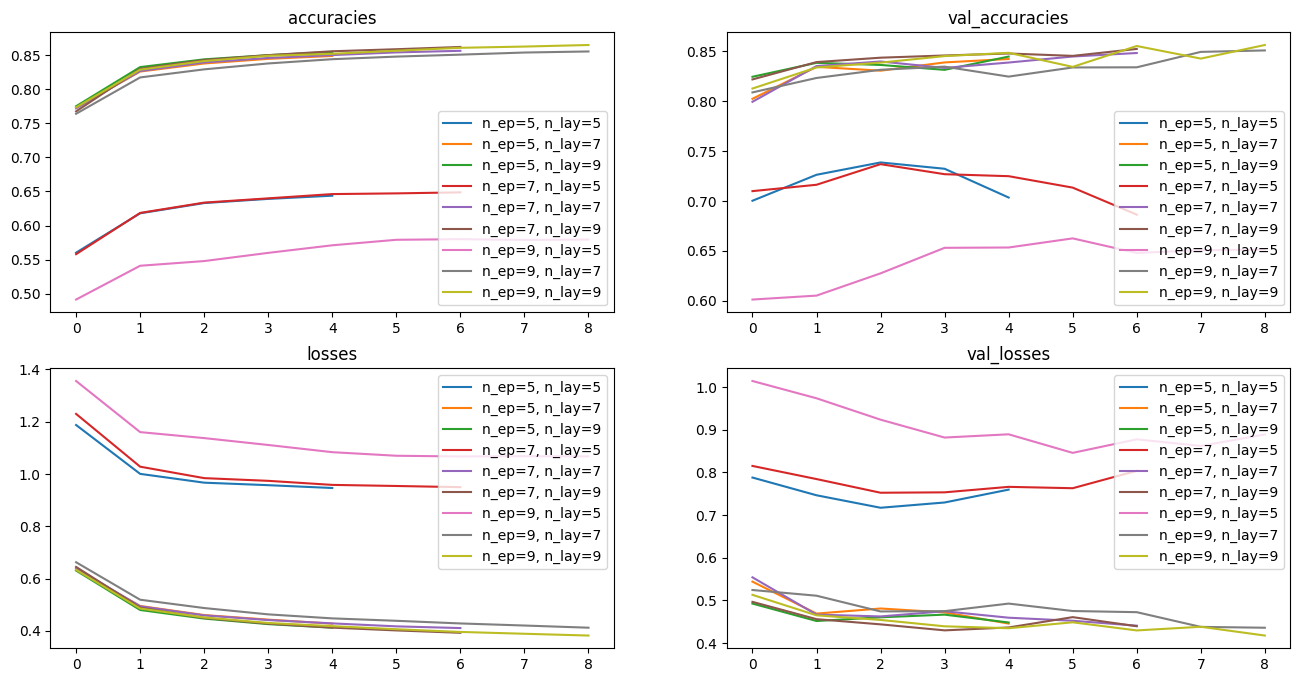

In [370]:
metrics = dict(sorted(metrics.items()))
plt.figure(figsize=(16, 8))
for i, gr in enumerate(['accuracies', 'val_accuracies', 'losses', 'val_losses']):
    for pair in metrics:
        plt.subplot(2, 2, i + 1)
        plt.plot(metrics[pair][gr], label=f"n_ep={pair[0]}, n_lay={pair[1]}")
        plt.title(gr)
        plt.legend()
plt.show()

### **Выводы**:
1. Пять слоев (Linear, ReLU, Dropout, Linear, LogSoftmax) дают не очень хорошие результаты *loss* и *accuracy* (а еще переобучаются при большом кол-ве эпох).
2. Пять эпох обучения недостаточно.
3. Лучшие значения *val_loss* и *val_accuracy* при **девяти слоях** (Linear, ReLU, Linear, ReLU, Linear, ReLU, Dropout, Linear, LogSoftmax) и **девяти эпохах обучения** (<font color='#c3c43b'>желто-зеленая</font> линия). При этом на семи слоях (Linear, ReLU, Linear, ReLU, Dropout, Linear, LogSoftmax) и девяти эпохах уже ничего особо не меняется, поэтому, кажется, наращивать слои уже нет особого смысла.

![conclusions](https://sun9-14.userapi.com/impg/WaSf8TC3UX0qAFuCn0m4IurTcnXeh5Lsp0z99A/bNhKh1fVADI.jpg?size=510x454&quality=96&sign=51ec696db526a8447f806bcae66da753&type=album)